In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

import networkx as nx
from networkx.convert_matrix import from_numpy_matrix
from networkx.algorithms.centrality import eigenvector_centrality, degree_centrality
from networkx.algorithms.matching import max_weight_matching, maximal_matching
from networkx import bipartite

import copy
import itertools

import imageio
import os

### Load Adj_matrix

In [2]:
adj_matrix = pd.read_csv('data/Adj_matrix_frm_2008_10_17.csv', index_col=0)
# adj_matrix = pd.read_csv('data/Adj_matrix_frm_2009_11_27.csv', index_col=0)

In [3]:
binary_adj_matrix = np.where((adj_matrix > -0.00001) & (adj_matrix<0.00001), 0, 1)

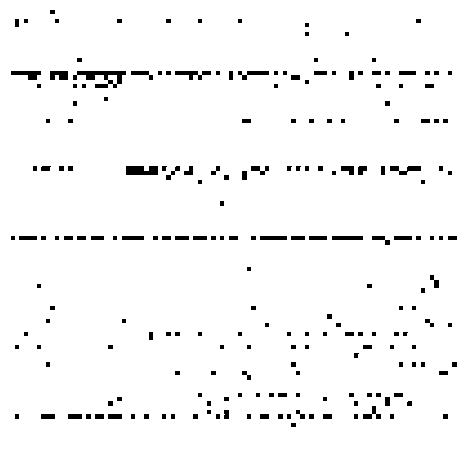

In [4]:
plt.figure(figsize=(8,8))
sns.heatmap(binary_adj_matrix, cmap='binary', xticklabels=[], yticklabels=[], cbar=False)


plt.savefig('adj_matrix_heatmap_binary.png', dpi=200, transparent = False)
plt.savefig('adj_matrix_heatmap_binary_transparent.png', dpi=200, transparent = True)
plt.show()

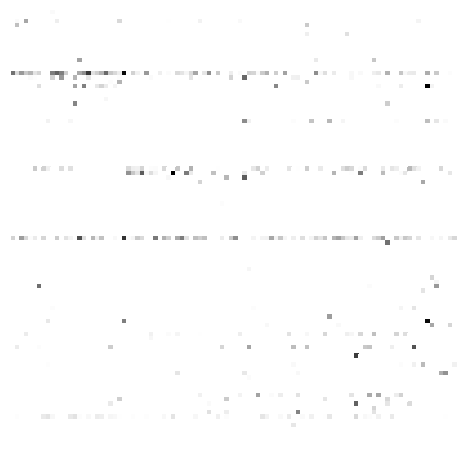

In [5]:
plt.figure(figsize=(8,8))
sns.heatmap(np.abs(adj_matrix.values), cmap='binary', xticklabels=[], yticklabels=[], cbar=False,
           vmin=0, vmax=0.8)

plt.savefig('adj_matrix_heatmap_discrete.png', dpi=200, transparent = False)
plt.savefig('adj_matrix_heatmap_discrete_transparent.png', dpi=200, transparent = True)
plt.show()

### make graph

In [6]:
graph = from_numpy_matrix(adj_matrix.values, create_using=nx.DiGraph())

In [7]:
#rename nodes


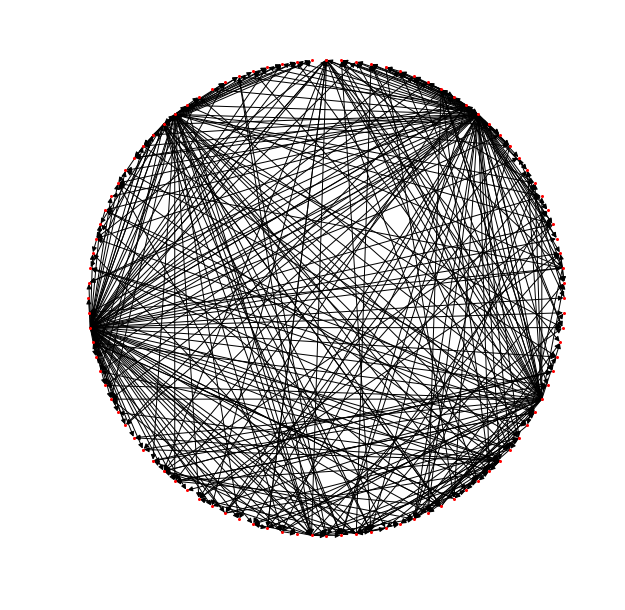

In [8]:
plt.figure(figsize=(8,8))
nx.draw_circular(graph, **{'node_size':4})

plt.savefig('simple_circular_graph.png', dpi=200, transparent = False)
plt.savefig('simple_circular_graph_transparent.png', dpi=200, transparent = True)
plt.show()

### Proper Layout of Graph

In [9]:
graph = nx.relabel.relabel_nodes(graph, dict(zip(range(len(adj_matrix.index.values)), adj_matrix.index.values)))

# arrange nodes in the four clusters as in the original
# 0-25,25-50,50-75,75-100
pos_bygroup = {}
offset = 2.5
offset_dict = {0:[-offset,-offset],1:[offset,-offset],
              2:[-offset,offset],3:[offset,offset]}
for i,start in enumerate(list(range(0,100,25))):
    graph_temp = from_numpy_matrix(adj_matrix.values[start:start+25,start:start+25])
    graph_temp = nx.relabel.relabel_nodes(graph_temp, dict(zip(range(len(adj_matrix.index.values[start:start+25])), adj_matrix.index.values[start:start+25])))
    temp_dict = nx.circular_layout(graph_temp, center=tuple(offset_dict[i]), scale=2)
    #print(i, start)
    for key in temp_dict:
        pos_bygroup[key] = temp_dict[key] / [1,1]
        

pos_og = copy.deepcopy(pos_bygroup)
pos = copy.deepcopy(pos_bygroup)

for p in pos:  # raise text positions
    #pos[p][1] += 0.002
    if pos[p][1]<-2.25:
        pos[p][1] -= 0.25
    if pos[p][1]>2.25:
        pos[p][1] += 0.25
    if (pos[p][1]>-2.25)&(pos[p][1]<0):
        pos[p][1] += 0.25
    if (pos[p][1]<2.25)&(pos[p][1]>0):
        pos[p][1] -= 0.25

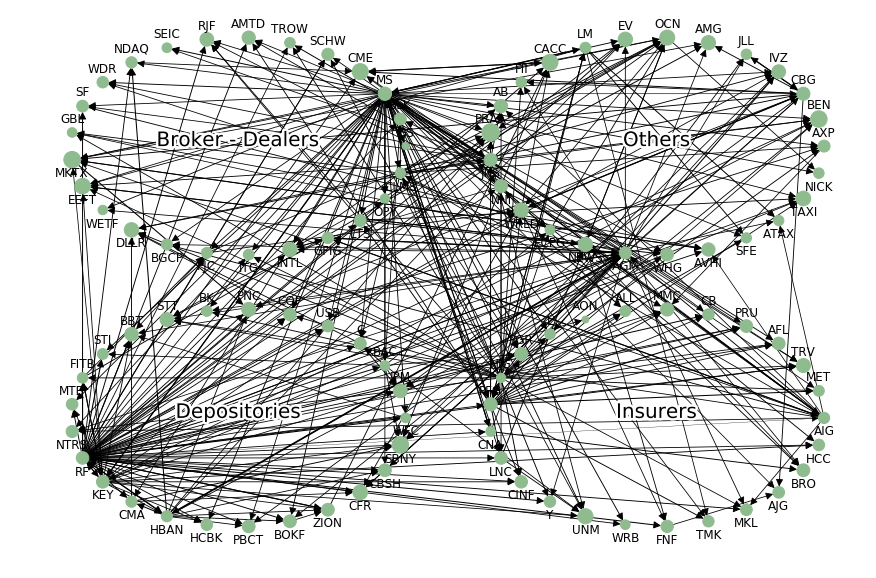

In [10]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,10)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_ymargin(0.05)
ax.set_xmargin(0.05)

centralities = eigenvector_centrality(graph)
centralities = np.array(list(centralities.values()))
sizes = 5 + 300*(centralities/(centralities.max()*2)) * 2

weights = [graph[u][v]['weight'] for u,v in graph.edges]
weights = (weights-np.min(weights))/(np.max(weights)-np.min(weights))
weights = 0.3 + 1.4*weights

kwargs = {'arrows':True, 'cmap' :'binary',
         'ax':ax,
         #'node_color':degreeness+degreeness.max(),'vmin':degreeness.min(), 'vmax':degreeness.max()*2
          #'node_color' : current_colors, #current_lambdas,
          'node_color':'darkseagreen',
          'vmin':0, 'vmax':20,
          'node_size' : sizes, 'width' : weights,
          'arrowsize': 15, 'edge_color' : 'black'
         }

nx.draw(graph, pos_og, with_labels= False,**kwargs)
nx.draw_networkx_labels(graph, pos)
txt = ax.text(-2.5,-2.5, 'Depositories',  ha='center', fontdict={'size':20})
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
txt = ax.text(2.5,-2.5, 'Insurers',  ha='center', fontdict={'size':20})
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
txt = ax.text(-2.5,2.5, 'Broker - Dealers',  ha='center', fontdict={'size':20})
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
txt = ax.text(2.5,2.5, 'Others',  ha='center', fontdict={'size':20})
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

plt.savefig('complex_graph_positions_labels.png', dpi=200, transparent = False)
plt.savefig('complex_graph_positions_labels_transparent.png', dpi=200, transparent = True)

plt.show()

### Convert to bipartite representation

for every node,
    split into in and out node
for every node,
    if outgoing connection from i to j
        have edge from i-out to j-in

In [11]:
adj_matrix.index

Index(['WFC', 'JPM', 'BAC', 'C', 'USB', 'COF', 'PNC', 'BK', 'STT', 'BBT',
       'STI', 'FITB', 'MTB', 'NTRS', 'RF', 'KEY', 'CMA', 'HBAN', 'HCBK',
       'PBCT', 'BOKF', 'ZION', 'CFR', 'CBSH', 'SBNY', 'AIG', 'MET', 'TRV',
       'AFL', 'PRU', 'CB', 'MMC', 'ALL', 'AON', 'L', 'PGR', 'HIG', 'PFG',
       'CNA', 'LNC', 'CINF', 'Y', 'UNM', 'WRB', 'FNF', 'TMK', 'MKL', 'AJG',
       'BRO', 'HCC', 'GS', 'BLK', 'MS', 'CME', 'SCHW', 'TROW', 'AMTD', 'RJF',
       'SEIC', 'NDAQ', 'WDR', 'SF', 'GBL', 'MKTX', 'EEFT', 'WETF', 'DLLR',
       'BGCP', 'PJC', 'ITG', 'INTL', 'GFIG', 'LTS', 'OPY', 'CLMS', 'AXP',
       'BEN', 'CBG', 'IVZ', 'JLL', 'AMG', 'OCN', 'EV', 'LM', 'CACC', 'FII',
       'AB', 'PRAA', 'JNS', 'NNI', 'WRLD', 'ECPG', 'NEWS', 'AGM', 'WHG',
       'AVHI', 'SFE', 'ATAX', 'TAXI', 'NICK'],
      dtype='object')

In [12]:
out_set_nodes = [str(i)+'+' for i in adj_matrix.index.values]
in_set_nodes = [str(i)+'-' for i in adj_matrix.index.values]

In [13]:
# make Bipartite graph
B = nx.Graph()
B.add_nodes_from(out_set_nodes, bipartite = 0)
B.add_nodes_from(in_set_nodes, bipartite = 1)
for _edge in list(graph.edges()):
    _u = _edge[0]
    _v = _edge[1]
    _edge_data = graph.get_edge_data(_u, _v)
    B.add_edge(_u + '+', _v + '-',**_edge_data)

In [14]:
b_pos = {}

# Update position for node from each group
b_pos.update((node, (index, 2)) for index, node in enumerate(out_set_nodes))
b_pos.update((node, (index, 1)) for index, node in enumerate(in_set_nodes))

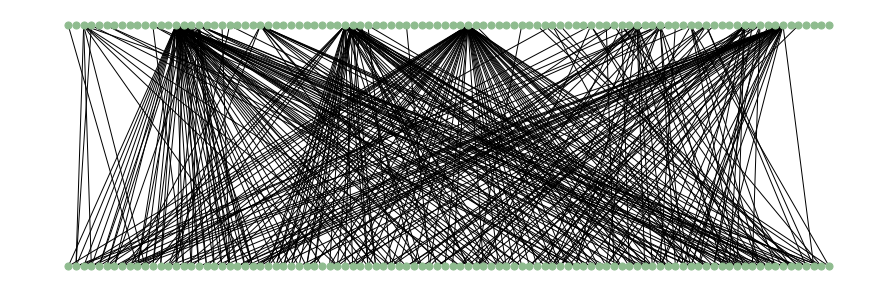

In [15]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,5)

kwargs = {'ax':ax,
          'node_color':'darkseagreen',
          'edge_color' : 'black',
          'node_size' : 50
         }

nx.draw(B, b_pos, **kwargs)
plt.savefig('complex_graph_bipartite_representation.png', dpi=200, transparent = False)
plt.savefig('complex_graph_bipartite_representation_transparent.png', dpi=200, transparent = True)

plt.show()

### Get max weight matching

In [16]:
matching_max_weight_result = max_weight_matching(B, maxcardinality =  True)

In [17]:
for edge in matching_max_weight_result:
    if (edge[0][-1] == edge[1][-1]):
        print('Error, two edges from the same set got matched')

In [18]:
i=0
for edge in B.edges():
    if edge in matching_max_weight_result:
        print(edge)
        i+=1
    if edge[::-1] in matching_max_weight_result:
        print(edge, 'A')
        i+=1
print(i)

('WFC+', 'BBT-') A
('BAC+', 'C-') A
('C+', 'JPM-') A
('COF+', 'AXP-')
('FITB+', 'KEY-') A
('RF+', 'HBAN-')
('KEY+', 'FITB-')
('CMA+', 'DLLR-')
('HBAN+', 'AGM-')
('BOKF+', 'ZION-')
('ZION+', 'RF-')
('AIG+', 'BGCP-') A
('HIG+', 'CINF-') A
('PFG+', 'HIG-')
('CNA+', 'MS-')
('LNC+', 'UNM-')
('FNF+', 'AJG-') A
('MS+', 'ALL-')
('CME+', 'CACC-') A
('NDAQ+', 'CME-') A
('SF+', 'WHG-')
('GBL+', 'AVHI-')
('MKTX+', 'PNC-') A
('EEFT+', 'NEWS-')
('PJC+', 'PRAA-')
('INTL+', 'GFIG-') A
('GFIG+', 'AIG-') A
('LTS+', 'TAXI-')
('CLMS+', 'AB-')
('AXP+', 'MMC-') A
('CBG+', 'WRLD-')
('IVZ+', 'SBNY-') A
('JLL+', 'CBG-')
('OCN+', 'NICK-') A
('LM+', 'ATAX-') A
('JNS+', 'TROW-') A
('NNI+', 'BRO-') A
('WRLD+', 'NNI-')
('ECPG+', 'OCN-') A
('NEWS+', 'EEFT-')
('AGM+', 'AMTD-')
('AVHI+', 'MKTX-') A
42


In [19]:
matched_edges_list = [1 
                      if (edge in list(matching_max_weight_result) or edge[::-1] in list(matching_max_weight_result)) 
                      else 0 
                      for edge in list(B.edges())]  
print(np.array(matched_edges_list).sum() == len(matching_max_weight_result))

True


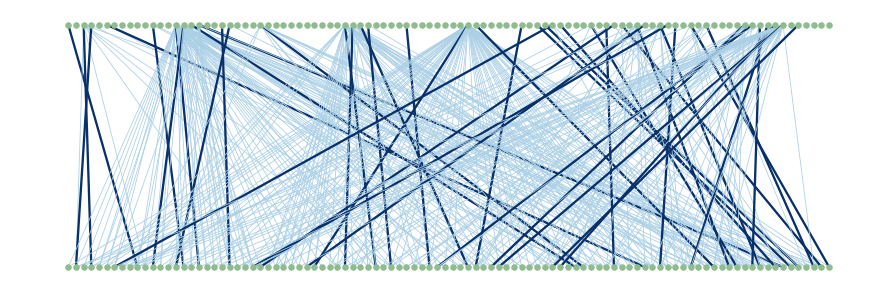

In [20]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,5)


kwargs = {'ax':ax,
          'node_color':'darkseagreen',
          'edge_color' : matched_edges_list,
          'node_size' : 30,
          'cmap' : 'grey',
          'edge_width' : 40,
          'edge_cmap':plt.cm.Blues,
          'edge_vmin':-0.5
         }

nx.draw(B, b_pos, width = 0.8+1.5*np.array(matched_edges_list),  **kwargs)
plt.savefig('matching_bipartite_representation.png', dpi=200, transparent = False)
plt.savefig('matching_bipartite_representation_transparent.png', dpi=200, transparent = True)

plt.show()

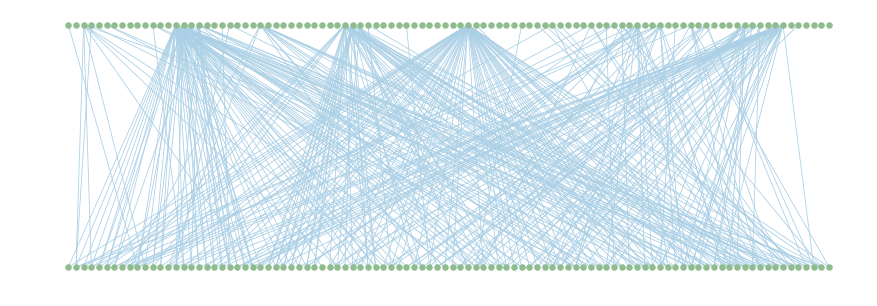

In [29]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,5)
for i in range(len(list(matching_max_weight_result))):
    ax.cla()
    matched_edges_list = [1 
                          if (edge in list(matching_max_weight_result)[:i] or 
                              edge[::-1] in list(matching_max_weight_result)[:i]) 
                          else 0 
                          for edge in list(B.edges())] 

    kwargs = {'ax':ax,
              'node_color':'darkseagreen',
              'edge_color' : matched_edges_list,
              'node_size' : 30,
              'cmap' : 'grey',
              'edge_width' : 40,
              'edge_cmap':plt.cm.Blues,
              'edge_vmin':-0.5,
              'edge_vmax':1
             }
    nx.draw(B, b_pos, width = 0.8+1.5*np.array(matched_edges_list),  **kwargs)
    plt.savefig('matching_movie/frame_' + str(i) + '_matching_bipartite_representation.png', dpi=200, transparent = False)
    break
plt.show()

In [32]:
images = []
for i in range(len(list(matching_max_weight_result))):
    filename = 'matching_movie/frame_' + str(i) + '_matching_bipartite_representation.png'
    images.append(imageio.imread(filename))
    print(filename)
#kwargs = { 'duration': 0.3 }
imageio.mimsave('matching_movie.mp4', images, fps=1.5)#, **kwargs)

matching_movie/frame_0_matching_bipartite_representation.png
matching_movie/frame_1_matching_bipartite_representation.png
matching_movie/frame_2_matching_bipartite_representation.png
matching_movie/frame_3_matching_bipartite_representation.png
matching_movie/frame_4_matching_bipartite_representation.png
matching_movie/frame_5_matching_bipartite_representation.png
matching_movie/frame_6_matching_bipartite_representation.png
matching_movie/frame_7_matching_bipartite_representation.png
matching_movie/frame_8_matching_bipartite_representation.png
matching_movie/frame_9_matching_bipartite_representation.png
matching_movie/frame_10_matching_bipartite_representation.png
matching_movie/frame_11_matching_bipartite_representation.png
matching_movie/frame_12_matching_bipartite_representation.png
matching_movie/frame_13_matching_bipartite_representation.png
matching_movie/frame_14_matching_bipartite_representation.png
matching_movie/frame_15_matching_bipartite_representation.png
matching_movie/fra

matching_movie/frame_41_matching_bipartite_representation.png


### Find matched nodes and minimum input set

In [21]:
matched_nodes = np.array(list(matching_max_weight_result)).flatten()
minimum_input_set = [node for node in in_set_nodes if (node not in matched_nodes)]
minimum_input_set_original = [name[:-1] for name in minimum_input_set]

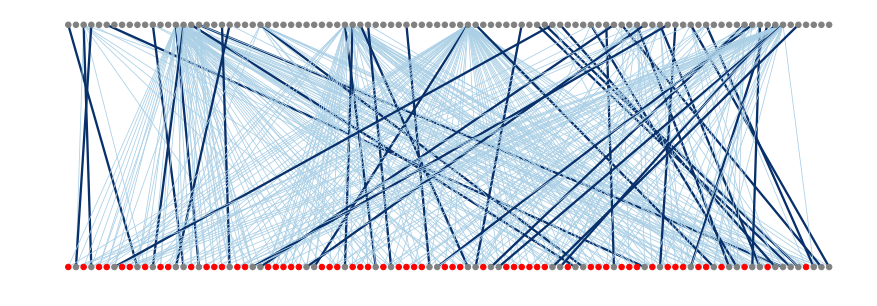

In [22]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,5)

node_colors = ['grey' if node not in minimum_input_set else 'red' for node in B.nodes()]

kwargs = {'ax':ax,
          'node_color': node_colors,
          'edge_color' : matched_edges_list,
          'node_size' : 30,
          'cmap' : 'grey',
          'edge_width' : 40,
          'edge_cmap':plt.cm.Blues,
          'edge_vmin':-0.5
         }

nx.draw(B, b_pos, width = 0.8+1.5*np.array(matched_edges_list),  **kwargs)
plt.savefig('minimum_input_set_bipartite_representation.png', dpi=200, transparent = False)
plt.savefig('minimum_input_set_bipartite_representation_transparent.png', dpi=200, transparent = True)

plt.show()

In [23]:
relevant_minimum_input_set = []
for node in minimum_input_set:
    if degree_centrality(B)[node] > 0:
        relevant_minimum_input_set.append(node)
print(len(minimum_input_set), len((relevant_minimum_input_set)))
print(relevant_minimum_input_set)

58 58
['WFC-', 'BAC-', 'USB-', 'COF-', 'BK-', 'STT-', 'STI-', 'MTB-', 'NTRS-', 'CMA-', 'HCBK-', 'PBCT-', 'BOKF-', 'CFR-', 'CBSH-', 'MET-', 'TRV-', 'AFL-', 'PRU-', 'CB-', 'AON-', 'L-', 'PGR-', 'PFG-', 'CNA-', 'LNC-', 'Y-', 'WRB-', 'FNF-', 'TMK-', 'MKL-', 'HCC-', 'GS-', 'BLK-', 'SCHW-', 'RJF-', 'SEIC-', 'NDAQ-', 'WDR-', 'SF-', 'GBL-', 'WETF-', 'PJC-', 'ITG-', 'INTL-', 'LTS-', 'OPY-', 'CLMS-', 'BEN-', 'IVZ-', 'JLL-', 'AMG-', 'EV-', 'LM-', 'FII-', 'JNS-', 'ECPG-', 'SFE-']


### Project back on original graph

### Plot original graph with key institutions

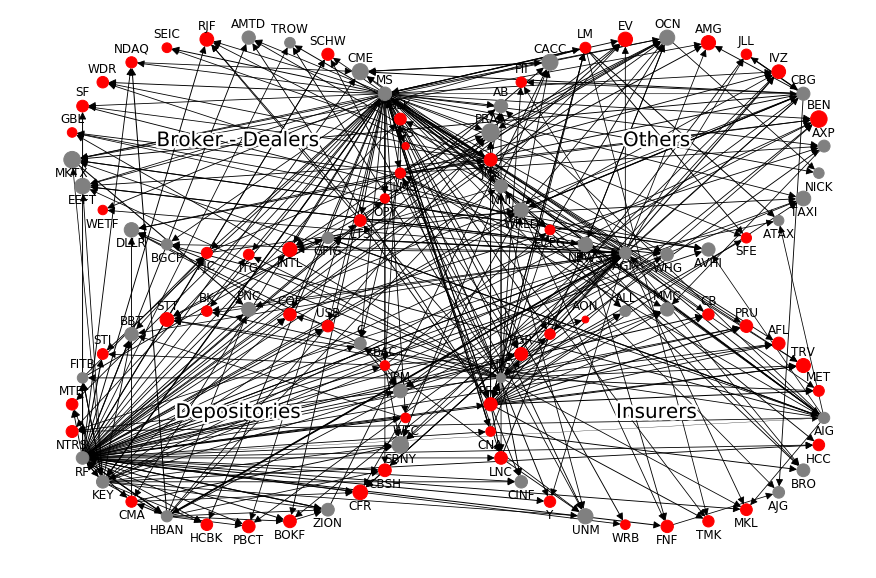

In [24]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15,10)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_ymargin(0.05)
ax.set_xmargin(0.05)

centralities = eigenvector_centrality(graph)
centralities = np.array(list(centralities.values()))
sizes = 5 + 300*(centralities/(centralities.max()*2)) * 2

weights = [graph[u][v]['weight'] for u,v in graph.edges]
weights = (weights-np.min(weights))/(np.max(weights)-np.min(weights))
weights = 0.3 + 1.4*weights

node_colors = ['grey' if node not in minimum_input_set_original else 'red' for node in graph.nodes()]

kwargs = {'arrows':True, 'cmap' :'binary',
         'ax':ax,
         #'node_color':degreeness+degreeness.max(),'vmin':degreeness.min(), 'vmax':degreeness.max()*2
          #'node_color' : current_colors, #current_lambdas,
          'node_color': node_colors,
          'vmin':0, 'vmax':20,
          'node_size' : sizes, 'width' : weights,
          'arrowsize': 15, 'edge_color' : 'black'
         }

nx.draw(graph, pos_og, with_labels= False,**kwargs)
nx.draw_networkx_labels(graph, pos)

txt = ax.text(-2.5,-2.5, 'Depositories',  ha='center', fontdict={'size':20})
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
txt = ax.text(2.5,-2.5, 'Insurers',  ha='center', fontdict={'size':20})
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
txt = ax.text(-2.5,2.5, 'Broker - Dealers',  ha='center', fontdict={'size':20})
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
txt = ax.text(2.5,2.5, 'Others',  ha='center', fontdict={'size':20})
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

plt.savefig('MIS_complex_graph_positions_labels.png', dpi=200, transparent = False)
plt.savefig('MIS_complex_graph_positions_labels_transparent.png', dpi=200, transparent = True)

plt.show()

### WIP

In [25]:
# taken from stack overflow

def all_maximal_matchings(T):

    maximal_matchings = []
    partial_matchings = [{(u,v)} for (u,v) in T.edges()]

    while partial_matchings:
        # get current partial matching
        m = partial_matchings.pop()
        nodes_m = set(itertools.chain(*m))

        extended = False
        for (u,v) in T.edges():
            if u not in nodes_m and v not in nodes_m:
                extended = True
                # copy m, extend it and add it to the list of partial matchings
                m_extended = set(m)
                m_extended.add((u,v))
                partial_matchings.append(m_extended)

        if not extended and m not in maximal_matchings:
            maximal_matchings.append(m)

    return maximal_matchings

T = nx.Graph()

T.add_edge('A','B')
T.add_edge('A','C')
T.add_edge('B','D')
T.add_edge('D','A')

print(all_maximal_matchings(T))

[{('A', 'C'), ('B', 'D')}, {('A', 'D')}, {('A', 'B')}]


In [26]:
# all_max_matchings_bipartite = all_maximal_matchings(B)